In [55]:
# Install torch and torchvision using pip
# pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

# Import and load data

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from glob import glob
from torch import nn, optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
# Define a function to open an image from a given path
def open_image(image_path, numpy_format=False):
    # Open the image using PIL library
    image = Image.open(image_path)
    # If numpy_format is True, convert the image to numpy array
    return image if not numpy_format else np.array(image)

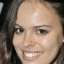

In [3]:
open_image('/home/glab/Desktop/kaggle/train_64/train_64/imgs/000000_64.jpg',
           numpy_format=False)

# Labels overview

In [4]:
# WARNING : PATH TO EDIT

# Path to the images folder
root = "/home/glab/Desktop/kaggle/train_64/train_64/imgs/"
# Path to the labels file
labels = pd.read_csv("/home/glab/Desktop/kaggle/train_df_challenge.csv")
# Path to the test images folder
root_kaggle = "/home/glab/Desktop/kaggle/test_64/test_64/imgs/"

In [5]:
# Add a column to the labels dataframe with the index
labels['index'] = labels.index
labels['path'] = labels['index'].apply(lambda index: f'{index:06}_64.jpg')
del labels['index']
labels.head()

,Female,Young,Attractive,Smiling,Oval_Face,Wavy_Hair,path
0,1.0,1.0,1.0,1.0,0.0,1.0,000000_64.jpg
1,0.0,1.0,0.0,1.0,1.0,0.0,000001_64.jpg
2,1.0,0.0,1.0,1.0,0.0,0.0,000002_64.jpg
3,1.0,1.0,1.0,1.0,1.0,0.0,000003_64.jpg
4,0.0,1.0,0.0,0.0,0.0,0.0,000004_64.jpg


In [6]:
# Check the first path
labels["path"].iloc[0]

'000000_64.jpg'

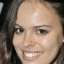

In [7]:
open_image(root + labels["path"].iloc[0], numpy_format=False)

In [8]:
labels.iloc[0, :5].to_numpy().astype("float")

array([1., 1., 1., 1., 0.])

In [9]:
# labels.to_csv("../labels.csv", index=False)

# Resampling Young/Attr

In [10]:
from sklearn.model_selection import train_test_split

labels_train, labels_test = train_test_split(labels, test_size=0.2)

In [11]:
# Query for estimate attr by gender
labels.query("Young == 0.0 and Attractive == 1.0")

,Female,Young,Attractive,Smiling,Oval_Face,Wavy_Hair,path
2,1.0,0.0,1.0,1.0,0.0,0.0,000002_64.jpg
16,0.0,0.0,1.0,1.0,1.0,0.0,000016_64.jpg
26,1.0,0.0,1.0,1.0,1.0,1.0,000026_64.jpg
69,0.0,0.0,1.0,1.0,0.0,0.0,000069_64.jpg
104,1.0,0.0,1.0,1.0,0.0,1.0,000104_64.jpg
...,...,...,...,...,...,...,...
162679,0.0,0.0,1.0,1.0,0.0,0.0,162679_64.jpg
162684,0.0,0.0,1.0,1.0,0.0,0.0,162684_64.jpg
162706,1.0,0.0,1.0,1.0,1.0,0.0,162706_64.jpg
162752,1.0,0.0,1.0,1.0,0.0,0.0,162752_64.jpg


In [12]:
# Female = 0 and Attractive = 1 : 19014
# Female = 1 and Attractive = 1 : 64589

# Young = 0 and Attractive = 1 : 5364
# Young = 1 and Attractive = 1 : 78239

In [13]:
B1 = labels_train[(labels_train["Young"] == 1) & (labels_train["Attractive"] == 1)]
B2 = labels_train[(labels_train["Young"] == 0) & (labels_train["Attractive"] == 1)]
B3 = labels_train[(labels_train["Young"] == 1) & (labels_train["Attractive"] == 0)]
B4 = labels_train[(labels_train["Young"] == 0) & (labels_train["Attractive"] == 0)]

print("B1:", B1.shape)
print("B2:", B2.shape)
print("B3:", B3.shape)
print("B4:", B4.shape)

B1: (62437, 7)
B2: (4255, 7)
B3: (38926, 7)
B4: (24598, 7)


In [14]:
diff = len(B1)-len(B2)
oversampled_B2 = B2.sample(n=diff, replace=True, random_state=42)
B2_surech = pd.concat([B2, oversampled_B2], ignore_index=True)

print("B1:", B1.shape)
print("B2:", B2_surech.shape)

B1: (62437, 7)
B2: (62437, 7)


In [15]:
diff = len(B3)-len(B4)
oversampled_B4 = B4.sample(n=diff, replace=True, random_state=42)
B4_surech = pd.concat([B4, oversampled_B4], ignore_index=True)

print("B3:", B3.shape)
print("B4:", B4_surech.shape)

B3: (38926, 7)
B4: (38926, 7)


In [16]:
B2_surech.path.value_counts()

path
044530_64.jpg    29
030385_64.jpg    28
006440_64.jpg    28
033828_64.jpg    28
072062_64.jpg    28
                 ..
103946_64.jpg     5
161583_64.jpg     5
088518_64.jpg     5
161961_64.jpg     5
002117_64.jpg     5
Name: count, Length: 4255, dtype: int64

In [17]:
dataframes = [B1, B2_surech, B3, B4_surech]

labels_di = pd.concat(dataframes, ignore_index=True)
labels_di.shape

(202726, 7)

In [18]:
labels_di = labels_di.sample(frac=1).reset_index(drop=True)

# Resampling Female/Attr

In [19]:
# Query for estimate attr by gender
labels.query("Female == 1.0 and Attractive == 0.0")

,Female,Young,Attractive,Smiling,Oval_Face,Wavy_Hair,path
13,1.0,1.0,0.0,0.0,0.0,0.0,000013_64.jpg
18,1.0,0.0,0.0,0.0,0.0,1.0,000018_64.jpg
19,1.0,1.0,0.0,1.0,0.0,0.0,000019_64.jpg
23,1.0,1.0,0.0,0.0,0.0,0.0,000023_64.jpg
28,1.0,1.0,0.0,0.0,0.0,0.0,000028_64.jpg
...,...,...,...,...,...,...,...
162753,1.0,1.0,0.0,0.0,0.0,0.0,162753_64.jpg
162756,1.0,1.0,0.0,0.0,0.0,0.0,162756_64.jpg
162757,1.0,0.0,0.0,0.0,0.0,1.0,162757_64.jpg
162758,1.0,0.0,0.0,1.0,0.0,1.0,162758_64.jpg


In [20]:
# Female = 1 and Attractive = 1 : 64589
# Female = 0 and Attractive = 1 : 19014
# x3.397

In [21]:
# Query for estimate attr by gender
labels_di.query("Female == 1.0 and Attractive == 0.0")

,Female,Young,Attractive,Smiling,Oval_Face,Wavy_Hair,path
0,1.0,0.0,0.0,1.0,0.0,0.0,151255_64.jpg
3,1.0,0.0,0.0,1.0,0.0,1.0,127003_64.jpg
7,1.0,1.0,0.0,0.0,1.0,0.0,067045_64.jpg
11,1.0,0.0,0.0,1.0,1.0,1.0,107007_64.jpg
21,1.0,1.0,0.0,0.0,0.0,0.0,108829_64.jpg
...,...,...,...,...,...,...,...
202670,1.0,0.0,0.0,0.0,0.0,1.0,110775_64.jpg
202684,1.0,0.0,0.0,0.0,1.0,1.0,149154_64.jpg
202685,1.0,1.0,0.0,0.0,0.0,0.0,053129_64.jpg
202699,1.0,1.0,0.0,1.0,0.0,1.0,026284_64.jpg


In [22]:
# Female = 1 and Attractive = 1 : 126246
# Female = 0 and Attractive = 1 : 48163
# x2.621

In [23]:
B1 = labels_di[(labels_di["Female"] == 1) & (labels_di["Attractive"] == 1)]
B2 = labels_di[(labels_di["Female"] == 0) & (labels_di["Attractive"] == 1)]
B3 = labels_di[(labels_di["Female"] == 1) & (labels_di["Attractive"] == 0)]
B4 = labels_di[(labels_di["Female"] == 0) & (labels_di["Attractive"] == 0)]

print("B1:", B1.shape)
print("B2:", B2.shape)
print("B3:", B3.shape)
print("B4:", B4.shape)

B1: (91091, 7)
B2: (33783, 7)
B3: (27488, 7)
B4: (50364, 7)


In [24]:
diff = len(B1)-len(B2)
oversampled_B2 = B2.sample(n=diff, replace=True, random_state=42)
B2_surech = pd.concat([B2, oversampled_B2], ignore_index=True)

print("B1:", B1.shape)
print("B2:", B2_surech.shape)

B1: (91091, 7)
B2: (91091, 7)


In [25]:
diff = len(B4)-len(B3)
oversampled_B3 = B3.sample(n=diff, replace=True, random_state=42)
B3_surech = pd.concat([B3, oversampled_B3], ignore_index=True)

print("B3:", B3_surech.shape)
print("B4:", B4.shape)

B3: (50364, 7)
B4: (50364, 7)


In [26]:
dataframes = [B1, B2_surech, B3_surech, B4]

labels_di = pd.concat(dataframes, ignore_index=True)
labels_di.shape

(282910, 7)

In [27]:
labels_di = labels_di.sample(frac=1).reset_index(drop=True)

# Split and DataLoader

In [28]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, labels, root):
        self.img_labels = labels
        self.root = root

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, index):
        img_path = self.root + self.img_labels['path'].iloc[index]
        image = open_image(img_path, numpy_format=True)
        label = self.img_labels.iloc[index, :6].to_numpy().astype('float')
        # Convert image and label to torch tensors
        image = torch.from_numpy(image)
        label = torch.from_numpy(label).float()
        # Pytorch works with C x H x W format
        image = image.permute(2, 0, 1)
        # Normalize the image
        image = image/255

        return image, label

In [29]:
# Define the dataset
dataset = CustomDataset(labels, root)

# Split the dataset into train and test
generator = torch.Generator().manual_seed(42)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=generator)

In [30]:
# Define the dataloader for train and test datasets
batch_size = 512
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

# DataLoader for DI correction

In [31]:
# Define the dataset
dataset_di = CustomDataset(labels_di, root)
dataset_test = CustomDataset(labels_test, root)

# Split the dataset into train and test
# generator = torch.Generator().manual_seed(42)
# train_size_di = int(0.8 * len(dataset_di))
# test_size_di = len(dataset_di) - train_size_di
# train_dataset_di, test_dataset_di = torch.utils.data.random_split(
#     dataset_di, [train_size_di, test_size_di], generator=generator)

In [32]:
# # Define the dataloader for train and test datasets
# batch_size = 512
# train_dataloader_di = DataLoader(
#     train_dataset_di, batch_size=batch_size, shuffle=True)
# test_dataloader_di = DataLoader(
#     test_dataset_di, batch_size=batch_size, shuffle=False)

In [33]:
# Define the dataloader for train and test datasets
batch_size = 512
train_dataloader_di = DataLoader(
    dataset_di, batch_size=batch_size, shuffle=True)
test_dataloader_di = DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False)

In [34]:
# Display the first row of train dataset
train_dataset_di.dataset[0]

NameError: name 'train_dataset_di' is not defined

# Metric and score function

In [35]:
def accuracy(y_pred, y_true):
    y_pred = (y_pred > 0.5).float()
    return (y_pred == y_true).float().mean() * 100

In [36]:
def disparate_impact_fem(prediction, labels):
    numerator = (prediction[:, 2] == 1) & (labels[:, 0] == 1)
    denominator = (prediction[:, 2] == 1) & (labels[:, 0] == 0)
    return numerator.sum() / (denominator.sum() + 1e-8)

In [37]:
def disparate_impact_youn(prediction, labels):
    numerator = (prediction[:, 2] == 1) & (labels[:, 1] == 1)
    denominator = (prediction[:, 2] == 1) & (labels[:, 1] == 0)
    return numerator.sum() / (denominator.sum() + 1e-8)

In [38]:
def custom_score(prediction, labels):

    accuracy_attr = accuracy(prediction[:, 2], labels[:, 2])

    DI_attr_fem = disparate_impact_fem(prediction, labels)
    DI_attr_youn = disparate_impact_youn(prediction, labels)

    accuracy_fem = accuracy(prediction[:, 0], labels[:, 0])
    accuracy_youn = accuracy(prediction[:, 1], labels[:, 1])
    accuracy_smil = accuracy(prediction[:, 3], labels[:, 3])
    accuracy_oval = accuracy(prediction[:, 4], labels[:, 4])
    accuracy_wavy = accuracy(prediction[:, 5], labels[:, 5])
    accuracy_label = (accuracy_fem + accuracy_youn + accuracy_smil + accuracy_oval + accuracy_wavy) / 5

    return 0.3 * (accuracy_attr-5*(DI_attr_youn-1)-2*(DI_attr_fem-1)) + 0.5 * accuracy_label

# Models

In [39]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv_bn_relu_stack = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(18432, 64), nn.ReLU(), nn.Linear(64, 6)
        )

    def forward(self, x):
        x = self.conv_bn_relu_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [40]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv_bn_relu_stack = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.linear = nn.Linear(18432, 64)

    def forward(self, x):
        x = self.conv_bn_relu_stack(x)
        x = self.flatten(x)
        z = self.linear(x)
        return z

In [41]:
class CNN2(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

        self.end = nn.Sequential(
            nn.ReLU(), nn.Linear(64, 6)
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.end(z)
        return y

In [48]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64, 128*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, 4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y
    
encoder = Encoder().to(device)
decoder = Decoder().to(device)
autoencoder = AutoEncoder(encoder, decoder).to(device)
cnn = CNN2(encoder).to(device)

# Iteration

In [78]:
model = CNN()

In [43]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda


In [53]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
autoencoder = AutoEncoder(encoder, decoder).to(device)
cnn = CNN2(encoder).to(device)

In [81]:
# Move the model to the device
model = model.to(device)

In [82]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [83]:
# Loss function
sigmoid = nn.Sigmoid()
bce = nn.BCELoss(reduction="mean")

In [84]:
# Train the model
epochs = 5
# Initialization
train_losses_dict = {}
test_losses_dict = {}
scores = []

for epoch in range(epochs):
    # List to store losses
    train_losses = []
    test_losses = []
    for phase in ['train', 'test']:
        dl = train_dataloader if phase == 'train' else test_dataloader
        # Bar to display progress
        for batch in (bar := tqdm(iter(dl))):
            ims, gt = batch
            # Move the images and gt to the device (like the model)
            ims = ims.to(device)
            gt = gt.to(device)

            output = sigmoid(model(ims))
            loss = bce(output, gt)
            # Minimize custom score
            # loss = custom_score(output, gt)
            prediction = (output > 0.5).float()
            score = custom_score(prediction, gt)
            scores.append(score.item())

            if phase == 'train':
                train_losses.append(loss.item())
                # Backpropagation and gradient descent
                # loss.requires_grad = True
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                bar.set_description(
                    f"Train {epoch+1} loss: {np.mean(train_losses).item():.4f}, Train score: {score.item():.4f}")
                scheduler.step()
            else:
                test_losses.append(loss.item())
                bar.set_description(
                    f"Test {epoch+1} loss: {np.mean(test_losses).item():.4f}, Test score: {score.item():.4f}")
        
        if phase == 'train':
            train_losses_dict[epoch+1] = np.mean(train_losses).item()

SyntaxError: invalid syntax (1986478563.py, line 18)

In [ ]:
a = [dataset_di[i][1] for i in range(9000, 9000+9000)]
a = torch.stack(a)


In [ ]:
a

tensor([[1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0., 1.],
        [1., 0., 1., 1., 0., 1.],
        ...,
        [0., 0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [ ]:
disparate_impact_youn(a, a)

tensor(2725)
tensor(3443)


tensor(0.7915)

In [ ]:
xx

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1., 0., 1.],
        [1., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.]])

In [ ]:
# Train the model
epochs = 5
# Initialization
train_losses_dict = {}
test_losses_dict = {}
scores = []

for epoch in range(epochs):
    # List to store losses
    train_losses = []
    test_losses = []
    for phase in ['train', 'test']:
        dl = train_dataloader_di if phase == 'train' else test_dataloader_di
        # Bar to display progress
        for batch in (bar := tqdm(iter(dl))):
            ims, gt = batch
            # Move the images and gt to the device (like the model)
            ims = ims.to(device)
            gt = gt.to(device)

            output = sigmoid(model(ims))
            loss = bce(output, gt)
            # Minimize custom score
            # loss = custom_score(output, gt)
            prediction = (output > 0.5).float()
            score = custom_score(prediction, gt)
            di_youn = disparate_impact_youn(prediction, gt)
            di_fem = disparate_impact_fem(prediction, gt)
            scores.append(score.item())

            if phase == 'train':
                train_losses.append(loss.item())
                # Backpropagation and gradient descent
                # loss.requires_grad = True
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                bar.set_description(
                    f"Train {epoch+1} loss: {np.mean(train_losses).item():.4f}, Train score: {score.item():.4f}, Train DI youn: {di_youn.item():.4f}, Train DI fem: {di_fem.item():.4f}, lr : {scheduler.get_last_lr()[0]:.6f}")
            else:
                test_losses.append(loss.item())
                bar.set_description(
                    f"Test {epoch+1} loss: {np.mean(test_losses).item():.4f}, Test score: {score.item():.4f}, Test DI youn: {di_youn.item():.4f}, Test DI fem: {di_fem.item():.4f}")

        if phase == 'train':
            train_losses_dict[epoch+1] = np.mean(train_losses).item()
            scheduler.step()

Train 1 loss: 0.3656, Train score: 69.2896, Train DI youn: 1.0714, Train DI fem: 1.1324, lr : 0.001000: 100%|██████████| 555/555 [02:01<00:00,  4.55it/s]
Test 1 loss: 0.3578, Test score: 48.6085, Test DI youn: 12.1429, Test DI fem: 2.7551: 100%|██████████| 64/64 [00:11<00:00,  5.49it/s]
Train 2 loss: 0.2664, Train score: 70.0564, Train DI youn: 0.8158, Train DI fem: 0.8904, lr : 0.000900: 100%|██████████| 555/555 [01:59<00:00,  4.63it/s]
Test 2 loss: 0.3717, Test score: 48.4654, Test DI youn: 11.7692, Test DI fem: 3.3684: 100%|██████████| 64/64 [00:11<00:00,  5.48it/s]
Train 3 loss: 0.2288, Train score: 72.1309, Train DI youn: 0.7802, Train DI fem: 1.0903, lr : 0.000810:  36%|███▌      | 200/555 [00:42<01:15,  4.67it/s]


KeyboardInterrupt: 

In [50]:
# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    # Train the model
    train_loss = 0
    for data in train_dataloader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = decoder(encoder(img))
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Print the loss
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss / len(train_dataloader.dataset)))


0.018110275268554688
0.04068635031580925
0.02394815906882286
0.022823866456747055
0.024724673479795456
0.023918485268950462
0.023232821375131607
0.022722532972693443
0.02146877720952034
0.02073671668767929
0.020907919853925705
0.020678043365478516
0.020357241854071617
0.02063966915011406
0.01984921097755432
0.01948319375514984
0.01896766573190689
0.018942466005682945
0.01851677894592285
0.018228501081466675
0.017713239416480064
0.017917297780513763
0.01811206340789795
0.017723308876156807
0.017804473638534546
0.017009668052196503
0.017142999917268753
0.01738348975777626
0.017712406814098358
0.015977708622813225
0.017066918313503265
0.016987930983304977
0.016675248742103577
0.016637658700346947
0.017048362642526627
0.01642046496272087
0.016139525920152664
0.016576290130615234
0.016148898750543594
0.015993576496839523
0.016750723123550415
0.01591888628900051
0.015595363453030586
0.01627380959689617
0.01605970226228237
0.015807384625077248
0.01575586386024952
0.015973880887031555
0.015640

KeyboardInterrupt: 

In [51]:
# empty nvidia
torch.cuda.empty_cache()

# Save model

In [ ]:
# Save the model with correct name
torch.save(model.state_dict(), '../models/cnn.pth')

# Graph

In [ ]:
# scores rolling mean
scores_roll = pd.Series(scores)
scores_roll = scores_roll.rolling(10).mean()
plt.plot(scores_roll)

In [ ]:
train_losses_dict

# Export for submission¶

In [ ]:
# Define a custom dataset class
class KaggleDataset(Dataset):
    def __init__(self, root_kaggle):
        self.root_kaggle = root_kaggle
        self.files_list = sorted(glob(self.root_kaggle + "*.jpg"))

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, index):
        img_path = self.files_list[index]
        image = open_image(img_path, numpy_format=True)
        # Convert image and label to torch tensors
        image = torch.from_numpy(image)
        # Pytorch works with C x H x W format
        image = image.permute(2, 0, 1)
        # Normalize the image
        image = image/255

        return image, img_path.split("/")[-1]

In [ ]:
# Define the dataset
kaggle_dataset = KaggleDataset(root_kaggle)

In [ ]:
# Define the dataloader for train and test datasets
batch_size = 256
kaggle_dataloader = DataLoader(
    kaggle_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
predictions_list = []
paths_list = []
for batch in (bar:= tqdm(iter(kaggle_dataloader))):
    images, paths = batch
    # Move the images and gt to the device (like the model)
    with torch.no_grad():
        images = images.to(device)
        outputs = sigmoid(model(images))
    # Append the prediction to the a list
    predictions = list((outputs > 0.5).detach().cpu().numpy().astype(int))
    predictions_list.extend(predictions)
    paths_list.extend(paths)

100%|██████████| 78/78 [00:05<00:00, 14.91it/s]


In [ ]:
col_names = ['ID', 'Female', 'Young', 'Attractive', 'Smiling', 'Oval_Face', 'Wavy_Hair']
df = pd.DataFrame({'ID': paths_list})

for i, col_name in enumerate(col_names[1:]):
    df[col_name] = [p[i] for p in predictions_list]

print(df.head())
# +1 for version
df.to_csv('../subs/submission01.csv', index=False)

              ID  Female  Young  Attractive  Smiling  Oval_Face  Wavy_Hair
0  000000_64.jpg       0      1           1        0          0          0
1  000001_64.jpg       0      1           1        0          1          1
2  000002_64.jpg       1      1           1        1          1          1
3  000003_64.jpg       1      1           1        0          1          0
4  000004_64.jpg       0      0           0        1          1          0


In [35]:
# 19962 is the correct value for submit
len(df)

NameError: name 'df' is not defined